In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
random.seed(123)
from matplotlib import pyplot as plt

import time
import os

In [2]:


use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

In [3]:
#visualization function

In [4]:
#dataset function

In [5]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
)

In [6]:
#Create train/val/test sets

In [7]:
from sklearn.model_selection import train_test_split
targets = trainset.targets
train_idx, val_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True, stratify=targets, random_state=123)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size=128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True
                                         )

In [8]:
#model architecture

In [9]:
# Define the model
class Net(nn.Module):
    def __init__(self, kernel_size, pool_function, nfilters_conv1, nfilters_conv2):
        super(Net, self).__init__()
        self.nfilters_conv2 = nfilters_conv2

        # CL1: 1 x 28 x 28 --> nfilters_conv1 x 28 x 28
        self.conv1 = nn.Conv2d(1, nfilters_conv1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(nfilters_conv1)
        self.pool1 = pool_function(2, 2)

        # CL2: nfilters_conv1 x 14 x 14 --> nfilters_conv2 x 14 x 14
        self.conv2 = nn.Conv2d(nfilters_conv1, nfilters_conv2, kernel_size=kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(nfilters_conv2)
        self.pool2 = pool_function(2, 2)

        # Fully connected layers
        self.linear1 = nn.Linear((nfilters_conv2 * 7 * 7), 256)
        self.dropout1 = nn.Dropout(0.5)

        self.linear2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(128, 10)

    def forward(self, x):
        # CL1 + BN + ReLU + Pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # CL2 + BN + ReLU + Pooling
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Flatten
        x = x.view(-1, self.nfilters_conv2 * 7 * 7)

        # Fully connected layers
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)

        x = F.relu(self.linear2(x))
        x = self.dropout2(x)

        x = self.linear3(x)
        return x

In [10]:
# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(kernel_size=3, pool_function=nn.MaxPool2d, nfilters_conv1=64, nfilters_conv2=128).to(device)


Epoch 1/10, Training Loss: 0.6585
Validation Loss: 0.3878, Accuracy: 86.08%
Epoch 2/10, Training Loss: 0.4173
Validation Loss: 0.2993, Accuracy: 89.17%
Epoch 3/10, Training Loss: 0.3507
Validation Loss: 0.2890, Accuracy: 89.53%
Epoch 4/10, Training Loss: 0.3176
Validation Loss: 0.2723, Accuracy: 90.20%
Epoch 5/10, Training Loss: 0.2966
Validation Loss: 0.2471, Accuracy: 91.02%
Epoch 6/10, Training Loss: 0.2723
Validation Loss: 0.2483, Accuracy: 91.37%
Epoch 7/10, Training Loss: 0.2530
Validation Loss: 0.2322, Accuracy: 91.69%
Epoch 8/10, Training Loss: 0.2425
Validation Loss: 0.2544, Accuracy: 90.53%
Epoch 9/10, Training Loss: 0.2248
Validation Loss: 0.2261, Accuracy: 92.00%
Epoch 10/10, Training Loss: 0.2092
Validation Loss: 0.2288, Accuracy: 91.97%
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.98      0.99       999
    Pullover       0.90      0.87      0.88      1000

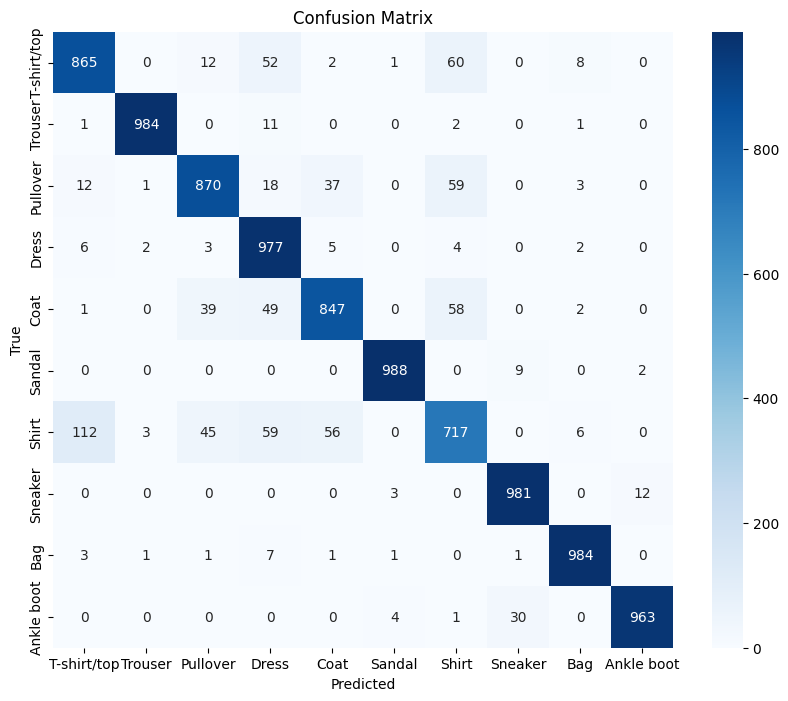

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



def train_model(model, trainloader, valloader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss / len(trainloader):.4f}')
        
        # Optionally, validate the model
        validate_model(model, valloader)

def validate_model(model, valloader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    print(f'Validation Loss: {val_loss / len(valloader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Train the model
train_model(model, trainloader, valloader, num_epochs=10)




from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Test the model
def test_model(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get predictions
labels, preds = test_model(model, testloader)

# Compute and print classification metrics
print("Classification Report:")
print(classification_report(labels, preds, target_names=classes))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


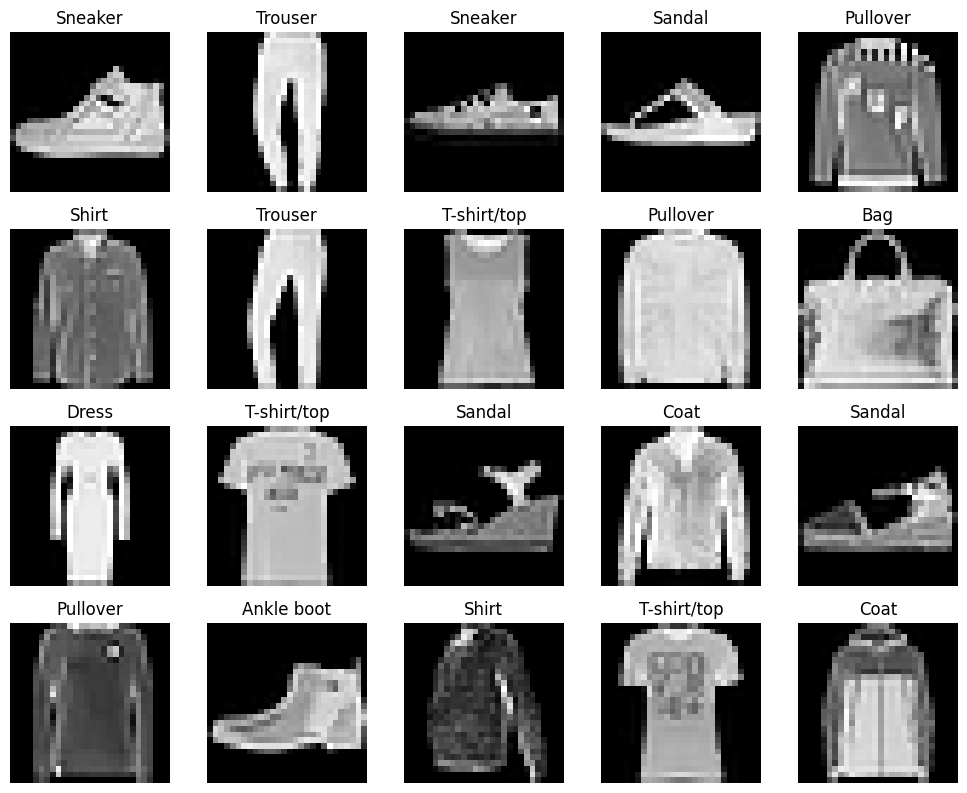

In [12]:
import matplotlib.pyplot as plt

# Function to display a grid of images with labels
def display_dataset(dataset, classes, num_images=20):
    # Create a figure to display the images
    plt.figure(figsize=(10, 10))
    
    for i in range(num_images):
        # Select a random image and its label from the dataset
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        
        # Plot the image
        plt.subplot(5, 5, i + 1)  # Arrange in a 5x5 grid
        plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 20 random images from the trainset
display_dataset(trainset, classes, num_images=20)


In [13]:
#attack

In [14]:
import torch
import torch.nn as nn
from torchattacks import FGSM, PGD


In [15]:

epsilon = 0.3

#fgsm
adversary_fgsm = FGSM(model, eps=epsilon)
#pgd
# Initialize PGD attack
adversary_pgd = PGD(
    model, eps=0.3, alpha=0.01, steps=10, random_start=True
)


In [16]:
# Function to generate adversarial examples and evaluate
def evaluate_adversarial_attack(model, dataloader, attack, attack_name):
    model.eval()
    all_preds = []
    all_labels = []
    original_images = []
    perturbed_images = []
    first_batch_processed = False
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Enable requires_grad for inputs
        inputs.requires_grad = True

        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        if not first_batch_processed:
            # Save original and perturbed images for visualization
            original_images.extend(inputs[:5].detach().cpu())
            perturbed_images.extend(adv_inputs[:5].detach().cpu())
            first_batch_processed = True
        
        # Run model on adversarial examples
        outputs = model(adv_inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Visualize original and perturbed images
    visualize_adversarial_images(original_images, perturbed_images, attack_name)

    # Evaluate the model
    print(f"\n{attack_name} Attack - Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{attack_name} Attack - Confusion Matrix")
    plt.show()

# Function to visualize original and perturbed images
def visualize_adversarial_images(original_images, perturbed_images, attack_name):
    plt.figure(figsize=(12, 6))
    for i in range(5):
        # Original images
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_images[i].squeeze().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Perturbed images
        plt.subplot(2, 5, i + 6)
        plt.imshow(perturbed_images[i].squeeze().numpy(), cmap='gray')
        plt.title("Perturbed")
        plt.axis('off')
    
    plt.suptitle(f"{attack_name} Attack - Original vs Perturbed Images", fontsize=16)
    plt.tight_layout()
    plt.show()



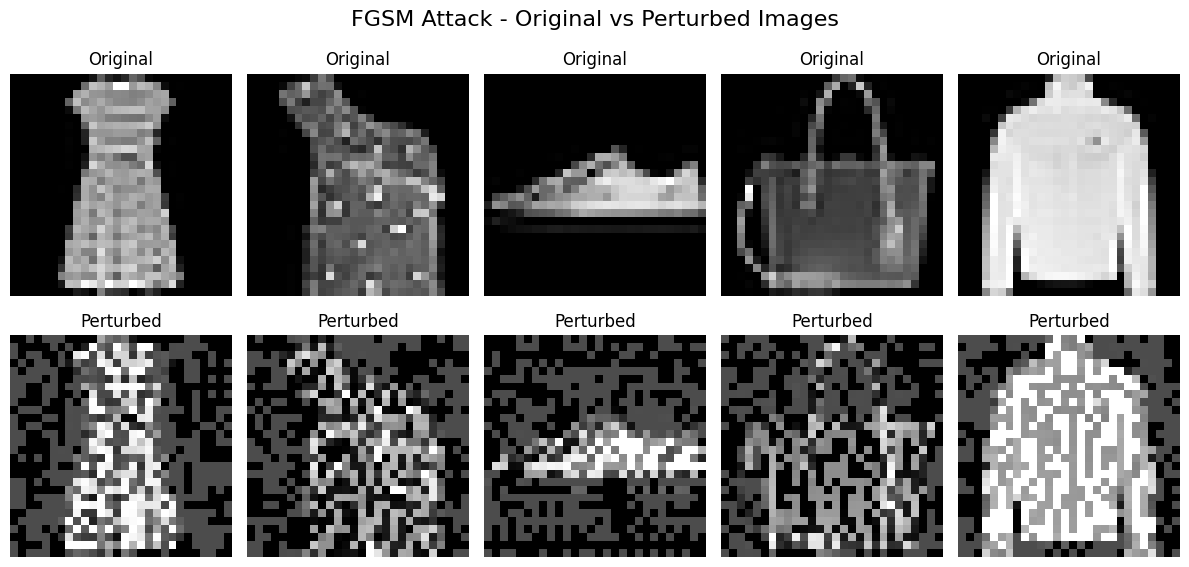


FGSM Attack - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.02      0.00      0.01       997
     Trouser       0.82      0.11      0.20       997
    Pullover       0.00      0.00      0.00      1000
       Dress       0.01      0.01      0.01       998
        Coat       0.00      0.00      0.00       998
      Sandal       0.88      0.60      0.71       999
       Shirt       0.01      0.07      0.02       998
     Sneaker       0.22      0.04      0.07      1000
         Bag       0.03      0.05      0.04       999
  Ankle boot       0.52      0.10      0.16       998

    accuracy                           0.10      9984
   macro avg       0.25      0.10      0.12      9984
weighted avg       0.25      0.10      0.12      9984



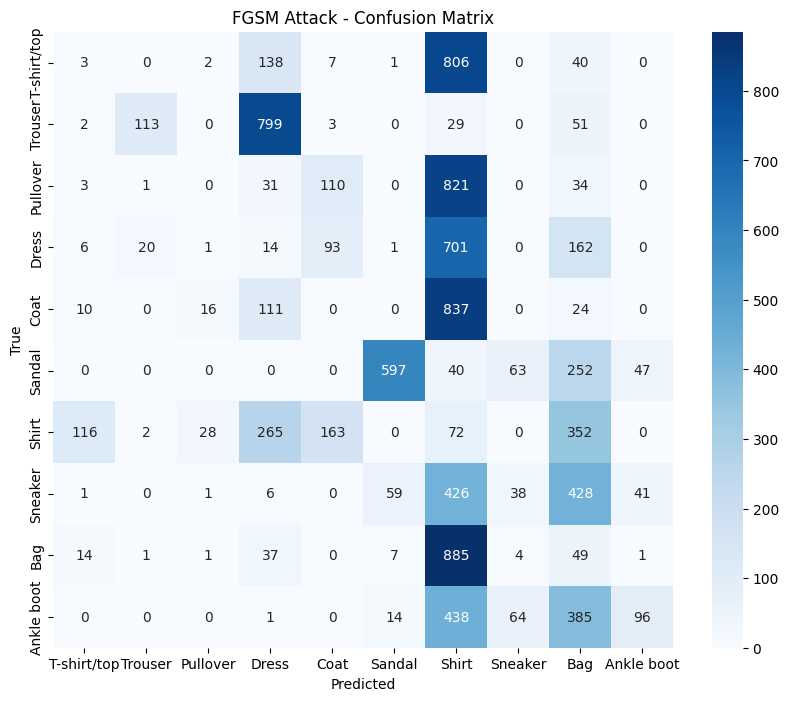

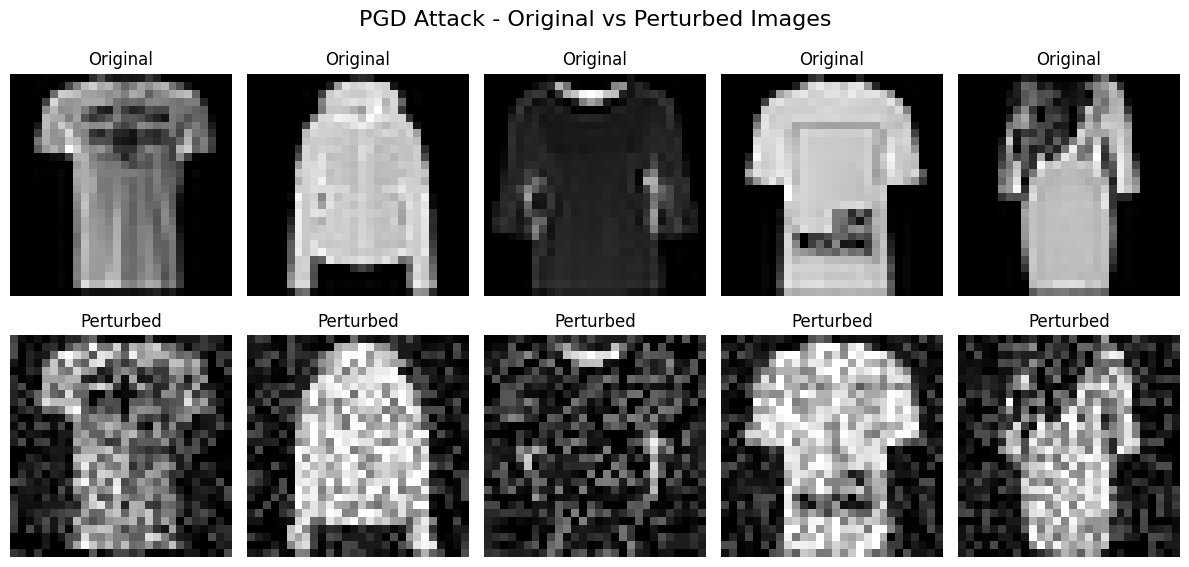


PGD Attack - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00       998
     Trouser       0.10      0.01      0.01       998
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00       997
        Coat       0.00      0.00      0.00      1000
      Sandal       0.43      0.06      0.11       997
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.00      0.00      0.00       997
         Bag       0.00      0.00      0.00       999
  Ankle boot       0.00      0.00      0.00       998

    accuracy                           0.01      9984
   macro avg       0.05      0.01      0.01      9984
weighted avg       0.05      0.01      0.01      9984



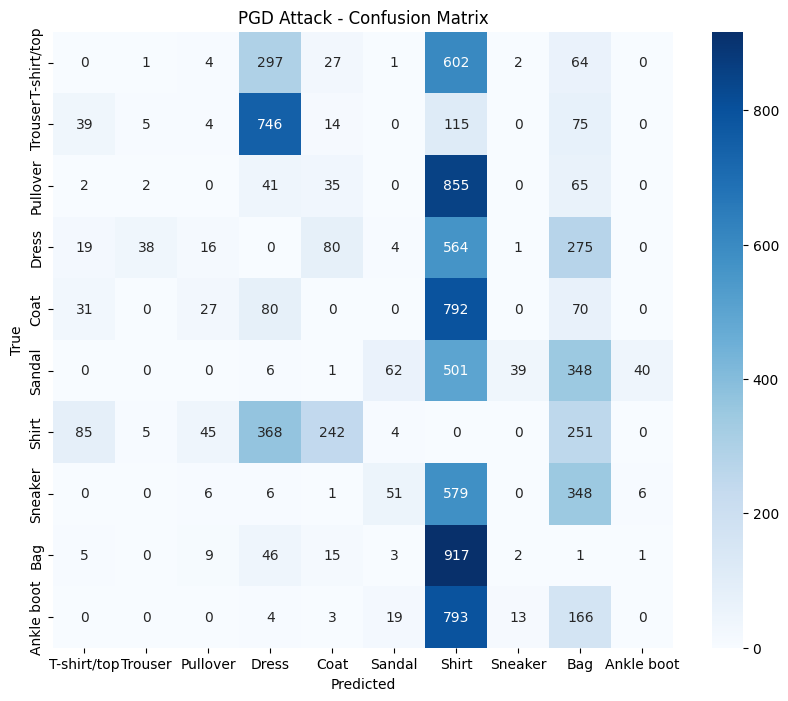

In [17]:
evaluate_adversarial_attack(model, testloader, adversary_fgsm, "FGSM")
evaluate_adversarial_attack(model, testloader, adversary_pgd, "PGD")


Training model with Mixed Adversarial Training (FGSM)...
Epoch 1/10, Loss: 0.8086
Epoch 2/10, Loss: 0.5539
Epoch 3/10, Loss: 0.4685
Epoch 4/10, Loss: 0.4311
Epoch 5/10, Loss: 0.3913
Epoch 6/10, Loss: 0.3454
Epoch 7/10, Loss: 0.3205
Epoch 8/10, Loss: 0.2950
Epoch 9/10, Loss: 0.2886
Epoch 10/10, Loss: 0.2725

FGSM Defense - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.87      0.89       999
     Trouser       0.99      0.95      0.97       996
    Pullover       0.92      0.94      0.93       999
       Dress       0.93      0.95      0.94      1000
        Coat       0.95      0.93      0.94       998
      Sandal       0.97      0.97      0.97       998
       Shirt       0.88      0.88      0.88      1000
     Sneaker       0.98      0.99      0.98       997
         Bag       0.93      0.97      0.95       997
  Ankle boot       0.98      0.98      0.98      1000

    accuracy                           0.94      9984
   

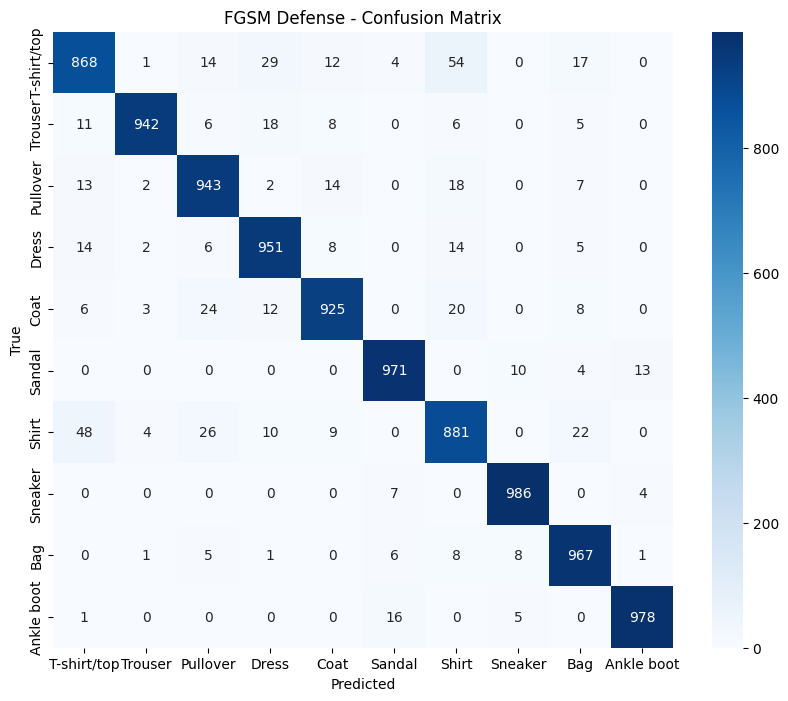

Training model with Mixed Adversarial Training (PGD)...
Epoch 1/10, Loss: 1.0734
Epoch 2/10, Loss: 0.7386
Epoch 3/10, Loss: 0.6890
Epoch 4/10, Loss: 0.6583
Epoch 5/10, Loss: 0.6373
Epoch 6/10, Loss: 0.6209
Epoch 7/10, Loss: 0.6121
Epoch 8/10, Loss: 0.5971
Epoch 9/10, Loss: 0.5857
Epoch 10/10, Loss: 0.5797

PGD Defense - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.62      0.72      0.66       998
     Trouser       0.91      0.68      0.78      1000
    Pullover       0.35      0.81      0.49       999
       Dress       0.52      0.69      0.60       999
        Coat       0.18      0.05      0.08      1000
      Sandal       0.72      0.54      0.62       998
       Shirt       0.03      0.01      0.01      1000
     Sneaker       0.76      0.64      0.69       996
         Bag       0.64      0.91      0.75       997
  Ankle boot       0.81      0.81      0.81       997

    accuracy                           0.59      9984
   ma

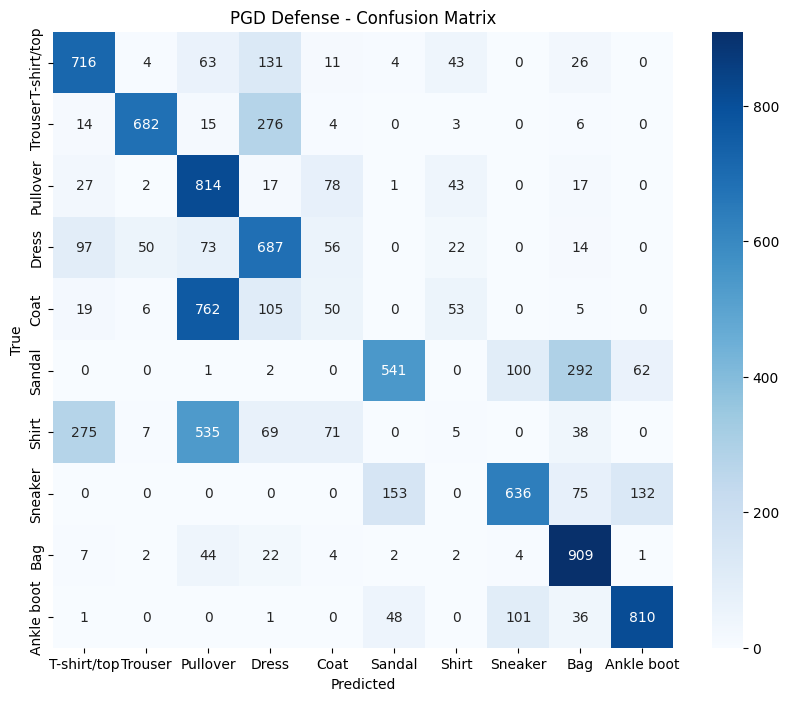

In [18]:
# Mixed Adversarial Training Function
def mixed_adversarial_training(model, trainloader, num_epochs, attack):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Enable requires_grad for inputs
            inputs.requires_grad = True

            # Generate adversarial examples for 50% of the batch
            model.eval()  # Temporarily switch to eval mode for attack generation
            half_batch_size = inputs.size(0) // 2
            clean_inputs = inputs[:half_batch_size]
            adv_inputs = attack(inputs[half_batch_size:], labels[half_batch_size:])
            model.train()  # Switch back to train mode

            # Combine clean and adversarial examples
            mixed_inputs = torch.cat([clean_inputs, adv_inputs], dim=0)
            mixed_labels = torch.cat([labels[:half_batch_size], labels[half_batch_size:]], dim=0)

            # Shuffle the mixed data
            idx = torch.randperm(mixed_inputs.size(0))
            mixed_inputs = mixed_inputs[idx]
            mixed_labels = mixed_labels[idx]

            # Forward pass
            optimizer.zero_grad()
            outputs = model(mixed_inputs)
            loss = criterion(outputs, mixed_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(trainloader):.4f}")

# Evaluation Function
def evaluate_model_on_attack(model, testloader, attack, attack_name):
    model.eval()
    all_preds = []
    all_labels = []

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Enable requires_grad for adversarial examples
        inputs.requires_grad = True

        # Temporarily switch model to eval mode for attack generation
        with torch.enable_grad():
            adv_inputs = attack(inputs, labels)

        # Run model on adversarial examples
        with torch.no_grad():
            outputs = model(adv_inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(f"\n{attack_name} Defense - Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{attack_name} Defense - Confusion Matrix")
    plt.show()

# Mixed Adversarial Training with FGSM
print("Training model with Mixed Adversarial Training (FGSM)...")
mixed_adversarial_training(model, trainloader, num_epochs=10, attack=adversary_fgsm)

# Evaluate model against FGSM
evaluate_model_on_attack(model, testloader, adversary_fgsm, "FGSM")

# Mixed Adversarial Training with PGD
print("Training model with Mixed Adversarial Training (PGD)...")
mixed_adversarial_training(model, trainloader, num_epochs=10, attack=adversary_pgd)

# Evaluate model against PGD
evaluate_model_on_attack(model, testloader, adversary_fgsm, "PGD")


Augmenting the dataset...
Training with augmented dataset and MAT (FGSM)...
Epoch 1/10, Loss: 0.9923
Epoch 2/10, Loss: 0.6936
Epoch 3/10, Loss: 0.6083
Epoch 4/10, Loss: 0.5625
Epoch 5/10, Loss: 0.5283
Epoch 6/10, Loss: 0.4963
Epoch 7/10, Loss: 0.4790
Epoch 8/10, Loss: 0.4651
Epoch 9/10, Loss: 0.4463
Epoch 10/10, Loss: 0.4301

FGSM Defense - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.95      0.95      0.95      1000
     Trouser       0.98      0.97      0.97      1000
    Pullover       0.96      0.94      0.95       999
       Dress       0.97      0.97      0.97       997
        Coat       0.96      0.97      0.97       996
      Sandal       0.98      1.00      0.99       999
       Shirt       0.93      0.93      0.93      1000
     Sneaker       0.99      1.00      0.99       998
         Bag       0.97      0.97      0.97       997
  Ankle boot       1.00      0.99      0.99       998

    accuracy                          

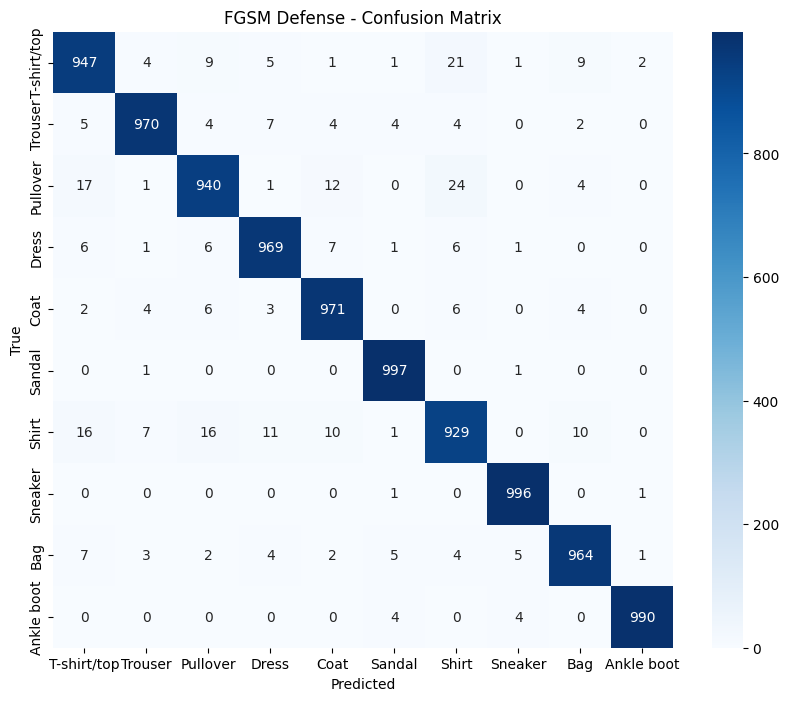

Training with augmented dataset and MAT (PGD)...
Epoch 1/10, Loss: 1.4166
Epoch 2/10, Loss: 1.1291
Epoch 3/10, Loss: 1.0805
Epoch 4/10, Loss: 1.0528
Epoch 5/10, Loss: 1.0304
Epoch 6/10, Loss: 1.0141


In [ ]:
import torch
import random
from torchvision import transforms

# Perform dataset augmentation
def augment_dataset(trainset):
    # Horizontal flip
    train_augmented = transforms.functional.hflip(trainset.data)

    # Adjust brightness randomly
    train_augmented = [
        transforms.functional.adjust_brightness(
            x, brightness_factor=random.choice([0.5, 0.75, 1.25, 1.5])
        ) for x in train_augmented
    ]
    train_augmented = torch.stack(train_augmented)

    # Apply Gaussian blur
    train_augmented = torch.stack(
        [transforms.functional.gaussian_blur(img.unsqueeze(0), kernel_size=3).squeeze(0)
         for img in train_augmented]
    )

    # Apply random rotation
    train_augmented = [
        transforms.functional.rotate(
            img.unsqueeze(0), angle=random.randrange(30, 330, 5)
        ).squeeze() for img in train_augmented
    ]
    train_augmented = torch.stack(train_augmented)

    return train_augmented

# Augment the dataset
print("Augmenting the dataset...")
augmented_data = augment_dataset(trainset)

# Combine original and augmented datasets
def create_augmented_dataloader(trainset, augmented_data, batch_size=128):
    # Create augmented labels (same as original labels)
    augmented_labels = trainset.targets

    # Combine original and augmented data
    combined_data = torch.cat((trainset.data, augmented_data), dim=0)
    combined_labels = torch.cat((trainset.targets, augmented_labels), dim=0)

    # Normalize the combined dataset
    combined_data = combined_data.unsqueeze(1).float() / 255.0  # Add channel dimension and normalize to [0, 1]

    # Create TensorDataset
    combined_dataset = torch.utils.data.TensorDataset(combined_data, combined_labels)

    # Create DataLoader
    augmented_loader = torch.utils.data.DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    return augmented_loader

# Create augmented DataLoader
trainloader_augmented = create_augmented_dataloader(trainset, augmented_data)

# Mixed Adversarial Training Function
def mixed_adversarial_training_augmented(model, trainloader_augmented, num_epochs, attack):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in trainloader_augmented:
            inputs, labels = inputs.to(device), labels.to(device)

            # Enable requires_grad for inputs
            inputs.requires_grad = True

            # Generate adversarial examples for 50% of the batch
            model.eval()  # Temporarily switch to eval mode for attack generation
            half_batch_size = inputs.size(0) // 2
            clean_inputs = inputs[:half_batch_size]
            adv_inputs = attack(inputs[half_batch_size:], labels[half_batch_size:])
            model.train()  # Switch back to train mode

            # Combine clean and adversarial examples
            mixed_inputs = torch.cat([clean_inputs, adv_inputs], dim=0)
            mixed_labels = torch.cat([labels[:half_batch_size], labels[half_batch_size:]], dim=0)

            # Shuffle the mixed data
            idx = torch.randperm(mixed_inputs.size(0))
            mixed_inputs = mixed_inputs[idx]
            mixed_labels = mixed_labels[idx]

            # Forward pass
            optimizer.zero_grad()
            outputs = model(mixed_inputs)
            loss = criterion(outputs, mixed_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(trainloader_augmented):.4f}")

# Train the model with augmented dataset and MAT
from torchattacks import FGSM, PGD

# Initialize attacks
fgsm_attack = FGSM(model, eps=0.3)
pgd_attack = PGD(model, eps=0.3, alpha=0.01, steps=10, random_start=True)

print("Training with augmented dataset and MAT (FGSM)...")
mixed_adversarial_training_augmented(model, trainloader_augmented, num_epochs=10, attack=fgsm_attack)

# Evaluation Function
def evaluate_model_on_attack(model, testloader, attack, attack_name):
    model.eval()
    all_preds = []
    all_labels = []

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Enable requires_grad for adversarial examples
        inputs.requires_grad = True

        # Temporarily switch model to eval mode for attack generation
        with torch.enable_grad():
            adv_inputs = attack(inputs, labels)

        # Run model on adversarial examples
        with torch.no_grad():
            outputs = model(adv_inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(f"\n{attack_name} Defense - Classification Report:")
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(all_labels, all_preds, target_names=trainset.classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.classes, yticklabels=trainset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{attack_name} Defense - Confusion Matrix")
    plt.show()

# Evaluate model on FGSM attack
evaluate_model_on_attack(model, testloader, fgsm_attack, "FGSM")

# Train the model with augmented dataset and MAT using PGD
print("Training with augmented dataset and MAT (PGD)...")
mixed_adversarial_training_augmented(model, trainloader_augmented, num_epochs=10, attack=pgd_attack)

# Evaluate model on PGD attack
evaluate_model_on_attack(model, testloader, pgd_attack, "PGD")
